# RAMEN RATINGS

We had acess to the ratings of a prestigious site of instant ramen with the following informations: <br /> 

**Review #**: the order of the rating <br /> 
**Brand**: the name of the brand <br /> 
**Variety**: the nam of the product <br /> 
**Style**: the format of the ramen package <br /> 
**Country**: brand's country<br /> 
**Stars**: the rating <br /> 
**Top Ten**: the top 10 rating per year <br /> 

Link of the dataset on Kaggle:
https://www.kaggle.com/residentmario/ramen-ratings

We aim to answer the following questions:
*     How is ramen manufacturing internationally distributed?
*     How are the ramen ratings distributed per the greater ramen productors? 
*     Is there a relation between the ratings and the product's style? 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For importing
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# For pre-processing
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

# For data visualization
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd

/kaggle/input/ramen-ratings/ramen-ratings.csv


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
ramen_list = pd.read_csv('/kaggle/input/ramen-ratings/ramen-ratings.csv')
ramen_list.head(5)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


# **Data manipulation**

## 1. Evaluating categorical values written twice differently:

In [3]:
brands= ramen_list["Brand"].unique()
brands.sort()
brands

array(['1 To 3 Noodles', '7 Select', '7 Select/Nissin', 'A-One',
       'A-Sha Dry Noodle', 'A1', 'ABC', 'Acecook', 'Adabi', 'Ah Lai',
       'Ajinatori', 'Amianda', 'Amino', "Annie Chun's", 'Aroi',
       'Asia Gold', 'Asian Thai Foods', 'Authentically Asian', 'Azami',
       'Baijia', 'Baixiang Noodles', 'Baltix', 'Bamee', 'Batchelors',
       'Binh Tay', 'Bon Go Jang', 'Bonasia', 'Boss', 'CJ CheilJedang',
       "Campbell's", 'Cap Atoom Bulan', 'CarJEN', "Chaudhary's Wai Wai",
       'Chencun', 'Chering Chang', 'Chewy', 'Chikara', 'China Best',
       "Ching's Secret", 'Chorip Dong', 'ChoripDong', 'Choumama',
       'Chuan Wei Wang', 'Cintan', 'Conimex', 'Crystal Noodle',
       'Curry Prince', 'Daddy', 'Daifuku', 'Daikoku', 'Daraz', 'Deshome',
       'Doll', 'Dongwon', "Dr. McDougall's", 'Dragonfly', 'Dream Kitchen',
       'E-Zee', 'E-mi', 'Eat & Go', 'Econsave', 'Emart', 'FMF',
       'Fantastic', "Farmer's Heart", 'Fashion Food', 'Fashion Foods',
       'Foodmon', 'Forest Noodle

We see that there are some brands with duplicated nouns with some variation as 'Wu Mu', 'Chorip Dong' and 'Fashion Food' and 'Mama'.
So we're going to filter some of this cases with the follwing function:

In [4]:
# Replaces rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

In [5]:
replace_matches_in_column(df=ramen_list, column="Brand", string_to_match="Chorip Dong", min_ratio = 47)
replace_matches_in_column(df=ramen_list, column="Brand", string_to_match="Fashion Food", min_ratio = 47)
replace_matches_in_column(df=ramen_list, column="Brand", string_to_match="Mama", min_ratio = 47)
replace_matches_in_column(df=ramen_list, column="Brand", string_to_match="Wu Mu", min_ratio = 47)

All done!
All done!
All done!
All done!


In [6]:
ramen_list["Style"].unique()

array(['Cup', 'Pack', 'Tray', 'Bowl', 'Box', 'Can', 'Bar', nan],
      dtype=object)

In [7]:
countries= ramen_list["Country"].unique()
countries.sort()
countries

array(['Australia', 'Bangladesh', 'Brazil', 'Cambodia', 'Canada', 'China',
       'Colombia', 'Dubai', 'Estonia', 'Fiji', 'Finland', 'Germany',
       'Ghana', 'Holland', 'Hong Kong', 'Hungary', 'India', 'Indonesia',
       'Japan', 'Malaysia', 'Mexico', 'Myanmar', 'Nepal', 'Netherlands',
       'Nigeria', 'Pakistan', 'Philippines', 'Poland', 'Sarawak',
       'Singapore', 'South Korea', 'Sweden', 'Taiwan', 'Thailand', 'UK',
       'USA', 'United States', 'Vietnam'], dtype=object)

In [8]:
duplicates = ramen_list["Review #"].duplicated().sum()
duplicates

0

## 2.  Evaluating missing row values per columns:

In [9]:
missing_values_counter = ramen_list.isnull().sum()
print(missing_values_counter[0:7])

lines_quantity = len(ramen_list)
print("Quantity of rows/lines:",lines_quantity)

Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64
Quantity of rows/lines: 2580


In [10]:
ramen_list_fill_style = ramen_list.copy()

# Locate the null cells
print("Null cells: \n",ramen_list_fill_style.loc[(ramen_list_fill_style['Style'].isnull())],"\n",80*"_")

Null cells: 
       Review #   Brand            Variety Style Country Stars Top Ten
2152       428  Kamfen     E Menm Chicken   NaN   China  3.75     NaN
2442       138    Unif  100 Furong Shrimp   NaN  Taiwan     3     NaN 
 ________________________________________________________________________________


In [11]:
# Assigning neighbor values in the column 'Style' for missing cells
ramen_list_fill_style['Style'] = ramen_list_fill_style['Style'].fillna(method='bfill', axis=0).fillna(0)

# To confirm if it worked
ramen_list_fill_style.loc[(ramen_list_fill_style['Style'].isnull())]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten


In [12]:
# Evaluating the stars character type
type(ramen_list_fill_style["Stars"][1])

str

In [13]:
# Converting the column's format to numerical and verifying if there's no null value
ramen_list_fill_style["Stars"] = pd.to_numeric(ramen_list_fill_style["Stars"], errors='coerce')
#Verifying if there is null values
ramen_list_fill_style.loc[ramen_list_fill_style["Stars"].isnull()]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
32,2548,Ottogi,Plain Instant Noodle No Soup Included,Pack,South Korea,NaN,NaN
122,2458,Samyang Foods,Sari Ramen,Pack,South Korea,NaN,NaN
993,1587,Mi E-Zee,Plain Noodles,Pack,Malaysia,NaN,NaN


In [14]:
# Adopting the same value from the cell above in the column 'Stars' to the null values evaluations
ramen_list_fill_style['Stars'] = ramen_list_fill_style['Stars'].fillna(method='bfill', axis=0).fillna(0)

# To confirm if it worked
ramen_list_fill_style.loc[(ramen_list_fill_style['Stars'].isnull())]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten


## 3. Data Visualization

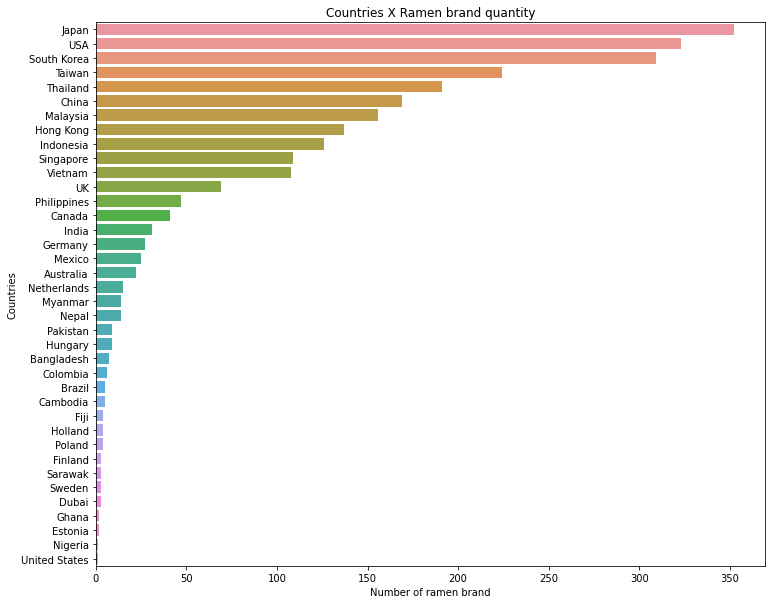

In [15]:
plt.figure(figsize=(12,10))
sns.countplot(data=ramen_list_fill_style, y="Country", order=ramen_list_fill_style['Country'].value_counts().index)
plt.title('Countries X Ramen brand quantity')
plt.xlabel('Number of ramen brand')
plt.ylabel("Countries")
#plt.legend(loc='best') # loc=best - legend of the dataset 
plt.show()

In [16]:
# Style percentage
style_per_quantity = ramen_list_fill_style["Style"].value_counts()/(len(ramen_list_fill_style))*100
print("Style percentage:\n",style_per_quantity)

Style percentage:
 Pack    59.379845
Bowl    18.682171
Cup     17.441860
Tray     4.186047
Box      0.232558
Can      0.038760
Bar      0.038760
Name: Style, dtype: float64


In [17]:
ramen_list_fill_style.describe()

,Review #,Stars
count,2580.000000,2580.000000
mean,1290.500000,3.654787
std,744.926171,1.014769
min,1.000000,0.000000
25%,645.750000,3.250000
50%,1290.500000,3.750000
75%,1935.250000,4.250000
max,2580.000000,5.000000


From the above metrics, we can see that a significantly part of the ratings are above 2.5. More specifically, 75% have a rating greater than 3.25.

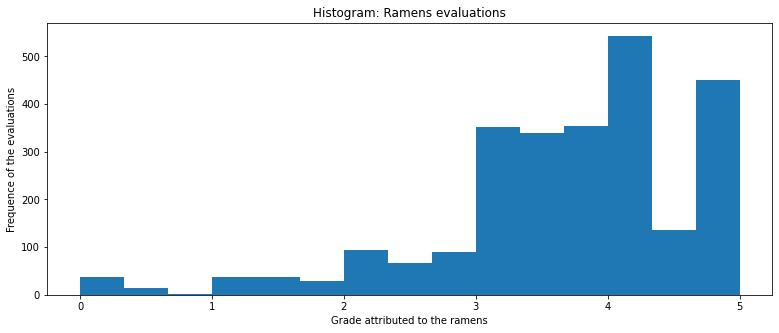

In [18]:
plt.figure(figsize=(13,5))
plt.hist(ramen_list_fill_style['Stars'],bins=15, histtype='bar')
plt.title('Histogram: Ramen''s evaluations')
plt.xlabel('Grade attributed to the ramens')
plt.ylabel("Frequence of the evaluations")
plt.show()

## Crossing dimensions

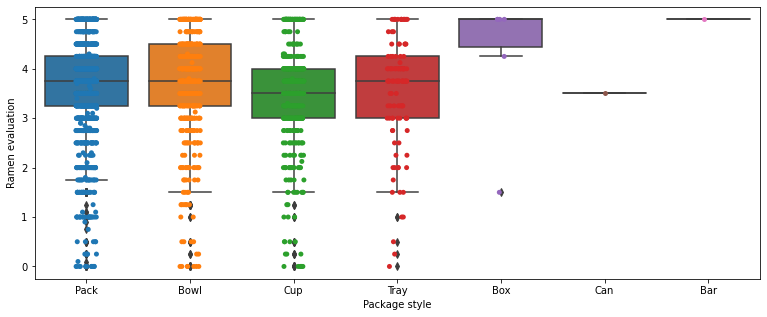

In [19]:
# Box plotting ramen rating x style of the package
plt.figure(figsize=(13,5))
sns.boxplot(x=ramen_list_fill_style["Style"],y=ramen_list_fill_style["Stars"], order=['Pack','Bowl','Cup','Tray','Box','Can','Bar'])
sns.stripplot(x=ramen_list_fill_style["Style"], y=ramen_list_fill_style["Stars"],order=['Pack','Bowl','Cup','Tray','Box','Can','Bar'])
plt.xlabel('Package style')
plt.ylabel('Ramen evaluation')
plt.show()

Selecting the 5 countries that owns more brands in order to do map their ratings: 

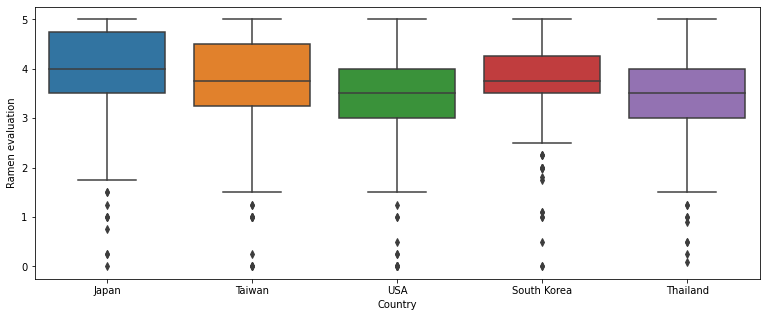

In [20]:
# Box plotting ramen rating x style of the package
plt.figure(figsize=(13,5))
sns.boxplot(x=ramen_list_fill_style["Country"],y=ramen_list_fill_style["Stars"], order=['Japan','Taiwan','USA','South Korea','Thailand'])
plt.xlabel('Country')
plt.ylabel('Ramen evaluation')
plt.show()

## 4. Conclusions

Summaring some of our observations. We have:
*     How is ramen manufacturing internationally distributed?</br>
The major productors countries are at the Asian continent. With Japan as the owner of more than 320 brands.
*     How are the ramen ratings distributed per the greater ramen productors?</br>
Japan is the country with more than 50% of its ramen production score above 4.0.
*     Is there a relation between the ratings and the product's style?</br>
The 'pack' format is responsible for about 59.4% of the evaluations. Considering the 3 major products formats(pack, bowl and cup), the bowl type received a better evaluation for more than 50% of its products. 